<a href="https://colab.research.google.com/github/ghanbarzadeh/Course_MachineVision_2021/blob/master/TA/Computer%2520Homeworks/CHW1/CHW1_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocessing

In [ ]:
!wget https://web.stanford.edu/class/cs315b/images/gates.png

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

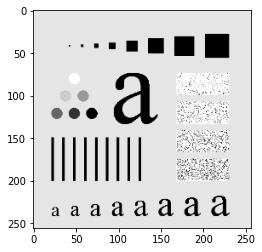

In [27]:
img = cv2.imread('/content/Fig4.11(a).jpg', cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (256, 256)) 
h, w = img.shape
plt.imshow(img, cmap="gray")
plt.show()

#Add noise

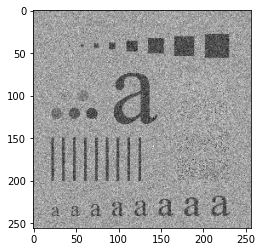

True

In [37]:
A = (img.max() - img.min())/2 #255/2
std = A/10**(6/20)
noise = np.random.normal(scale=std, size=img.shape)
noise_img = img + noise

plt.imshow(noise_img, cmap="gray")
plt.show()

cv2.imwrite("image_noise.png", noise_img)

# Gradient Calculation

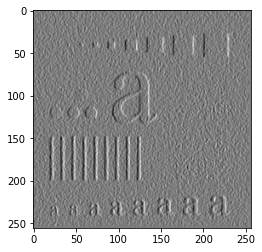

True

In [39]:
def calc_gradient(image):
    Gx_kernel = np.array([[-1, 0, 1],
                          [-2, 0, 2],
                          [-1, 0, 1]])
    Gy_kernel = np.array([[-1, -2, -1], 
                          [0, 0, 0], 
                          [1, 2, 1]])
    Gx = np.zeros((h, w))
    Gy = np.zeros((h, w))
    G = np.zeros((h, w))
    for x in range(1, h-2):
        for y in range(1, w-2):
            Gx[x, y] = np.sum(image[x:x+3, y:y+3] * Gx_kernel)
            Gy[x, y] = np.sum(image[x:x+3, y:y+3] * Gy_kernel)
    G = np.sqrt(Gx**2 + Gy**2)
    return Gx, Gy, G

image_Gx, image_Gy, image_G = calc_gradient(noise_img)

plt.imshow(image_Gx, cmap="gray")
plt.show()

cv2.imwrite("image_Gx.png", image_Gx)
cv2.imwrite("image_Gy.png", image_Gy)
cv2.imwrite("image_G.png", image_G)

## NMS with linear interpolation

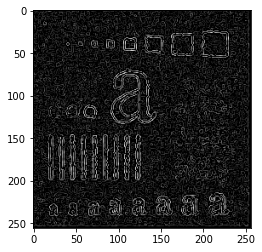

True

In [41]:
def NMS_inter(image):
    Gx_kernel = np.array([[-1, 0, 1],
                          [-2, 0, 2],
                          [-1, 0, 1]])
    Gy_kernel = np.array([[-1, -2, -1], 
                          [0, 0, 0], 
                          [1, 2, 1]])
    Gx = np.zeros((h, w))
    Gy = np.zeros((h, w))
    for x in range(1, h-2):
        for y in range(1, w-2):
            Gx[x, y] = np.sum(image[x:x+3, y:y+3] * Gx_kernel)
            Gy[x, y] = np.sum(image[x:x+3, y:y+3] * Gy_kernel)
    gradient_magnitude = np.sqrt(Gx**2 + Gy**2)
    gradient_dir = np.mod(np.arctan2(Gy, Gx), np.pi)
    # Pad the gradient magnitude to compensate for edge cases
    padded_gradient = np.zeros((h+2, w+2))
    padded_gradient[1:-1,1:-1] = gradient_magnitude[:,:]
    # NMS
    NMS_image = np.zeros((h, w))
    for x in range(h):
        for y in range(w):
            if (gradient_dir[x, y]>=0 and gradient_dir[x, y]<np.pi/4):
                p1 = np.tan(gradient_dir[x, y])*padded_gradient[x+2, y+2] + \
                    (1-np.tan(gradient_dir[x, y]))*padded_gradient[x+1, y+2]
                p2 = np.tan(gradient_dir[x, y])*padded_gradient[x, y] + \
                    (1-np.tan(gradient_dir[x, y]))*padded_gradient[x+1, y]
                if gradient_magnitude[x, y] > p1 and gradient_magnitude[x, y] > p2:
                    NMS_image[x, y] = gradient_magnitude[x, y]
            if (gradient_dir[x, y]>=np.pi/4 and gradient_dir[x, y]<np.pi/2):
                p1 = np.tan((np.pi/2-gradient_dir[x, y]))*padded_gradient[x+2, y+2] + \
                    (1-np.tan((np.pi/2-gradient_dir[x, y])))*padded_gradient[x+2, y+1]
                p2 = np.tan((np.pi/2-gradient_dir[x, y]))*padded_gradient[x, y] + \
                    (1-np.tan((np.pi/2-gradient_dir[x, y])))*padded_gradient[x, y+1]
                if gradient_magnitude[x, y] > p1 and gradient_magnitude[x, y] > p2:
                    NMS_image[x, y] = gradient_magnitude[x, y]
            if (gradient_dir[x, y]>=np.pi/2 and gradient_dir[x, y]<np.pi*3/4):
                p1 = np.tan((gradient_dir[x, y]-np.pi/2))*padded_gradient[x+2, y] + \
                    (1-np.tan((gradient_dir[x, y]-np.pi/2)))*padded_gradient[x+2, y+1]
                p2 = np.tan((gradient_dir[x, y]-np.pi/2))*padded_gradient[x, y+2] + \
                    (1-np.tan((gradient_dir[x, y]-np.pi/2)))*padded_gradient[x, y+1]
                if gradient_magnitude[x, y] > p1 and gradient_magnitude[x, y] > p2:
                    NMS_image[x, y] = gradient_magnitude[x, y]
            if (gradient_dir[x, y]>=np.pi*3/4 and gradient_dir[x, y]<=np.pi):
                p1 = np.tan((np.pi-gradient_dir[x, y]))*padded_gradient[x+2, y] + \
                    (1-np.tan((np.pi-gradient_dir[x, y])))*padded_gradient[x+1, y]
                p2 = np.tan((np.pi-gradient_dir[x, y]))*padded_gradient[x, y+2] + \
                    (1-np.tan((np.pi-gradient_dir[x, y])))*padded_gradient[x+1, y+2]
                if gradient_magnitude[x, y] > p1 and gradient_magnitude[x, y] > p2:
                    NMS_image[x, y] = gradient_magnitude[x, y]
    return NMS_image

image_NMS_inter = NMS_inter(image_G)

plt.imshow(image_NMS_inter, cmap="gray")
plt.show()

cv2.imwrite("image_NMS_interpol.png", image_NMS_inter)

# Thresholding

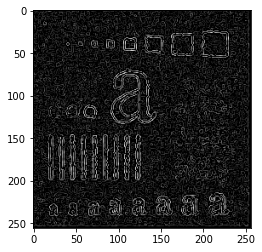

True

In [42]:
def thresholding(image):
    threshold = 50
    new_image = np.array(image)
    new_image[image<threshold] = 0
    return new_image

image_threshold = thresholding(image_NMS_inter)

plt.imshow(image_threshold, cmap="gray")
plt.show()

cv2.imwrite("image_threshold_simple.png", image_threshold)

# Bonus Section

## Double thresholding

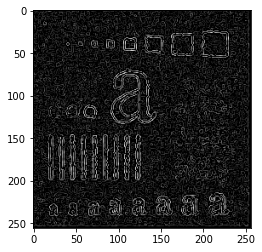

True

In [45]:
def hystersis_thresholding(image):
    Th = 75
    Tl = Th/2
    new_image = np.zeros((h, w))
    new_image[image>Th] = image[image>Th]
    # Pad the strong mask to compensate for edge cases
    strong_mask = np.full((h+2, w+2), False)
    strong_mask[1:-1,1:-1] = image>Th
    weak_mask = np.logical_and(image<=Th, image>=Tl)    
    for x in range(h):
        for y in range(w):
            if weak_mask[x, y]:
                if np.any(strong_mask[x:x+3, y:y+3]):
                    new_image[x, y] = image[x, y]
    return new_image

image_hystersis_thresholding = hystersis_thresholding(image_NMS_inter)

plt.imshow(image_hystersis_thresholding, cmap="gray")
plt.show()

cv2.imwrite("image_hystersis_thresholding.png", image_hystersis_thresholding)